# Visualize Generator Outputs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from torchgan.models import DCGANGenerator
from torch import nn
import torch

import numpy as np

import utils

/Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/collinschlager/miniforge3/envs/cs236g/bin/../lib/libpng16.16.dylib' (no such file), 

### Load in the parameters 

In [3]:
GAN_PARAMS_TO_LOAD = 'gan0.model'
GAN_CKPT_PATH = f'./model/{GAN_PARAMS_TO_LOAD}'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the meme background generator
generator_state_dict = torch.load(
    GAN_CKPT_PATH,
    map_location=torch.device(device)
)['generator']

generator = DCGANGenerator(
    encoding_dims=100,
    out_size=64,
    out_channels=3,
    step_channels=64,
    nonlinearity=nn.LeakyReLU(0.2),
    last_nonlinearity=nn.Tanh(),
).to(device).eval()

generator.load_state_dict(
    state_dict=generator_state_dict
)

<All keys matched successfully>

### Now we sample!

In [4]:
NUM_SAMPLES = 64

# normal
noise = generator.sampler(NUM_SAMPLES, device)[0]

# truncated normal
# noise = torch.fmod(torch.randn(NUM_SAMPLES, generator.encoding_dims),2)

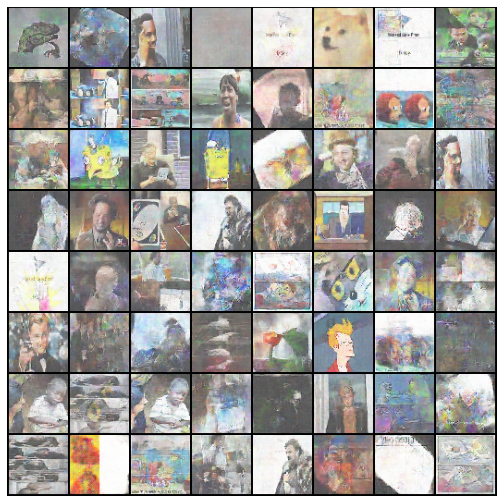

In [5]:
img = utils.tensor_to_image(generator(noise), ncol=8)

figure = plt.figure(figsize=(9, 9))
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

#### We can (linearly) interpolate between two points in Z-space

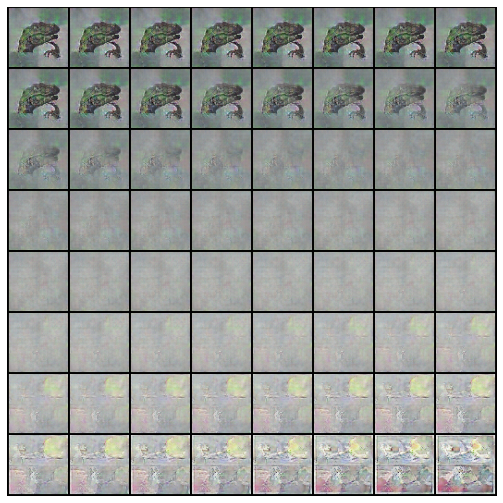

In [6]:
interpolated_noise = utils.interpolate(noise[0], noise[63])  # just two random start, end points

img = utils.tensor_to_image(generator(interpolated_noise), ncol=8)

figure = plt.figure(figsize=(9, 9))
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

#### Viewing a single output (woah!)

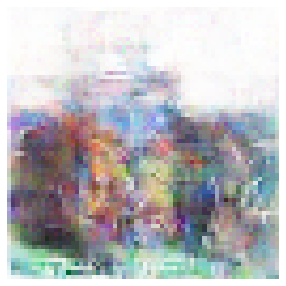

In [7]:
out = generator(noise)[46]
img = utils.tensor_to_image(out, ncol=1, padding=0)

plt.figure(figsize=(5,5))
plt.imshow(np.asarray(img))
plt.axis('off')
plt.show()

In [8]:
np.asarray(img).shape

(64, 64, 3)

# Generator Function

In [25]:
from inference import generate_background

In [26]:
out = generate_background(generator, device, truncated_normal=True)

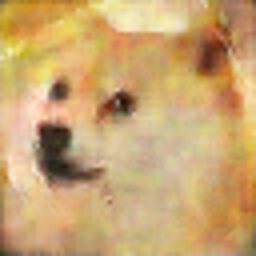

In [27]:
img = utils.tensor_to_image(out)
img.resize((256, 256))

# Caption Function

In [28]:
from inference import generate_caption
from dataset import MemeCaptionDataset
from captionmodel import EncoderCNN, DecoderRNN

ENCODER_PARAMS_TO_LOAD = 'encoder-440.pth'
DECODER_PARAMS_TO_LOAD = 'decoder-440.pth'
ENCODER_CKPT_PATH = f'./caption-model-ckpts/{ENCODER_PARAMS_TO_LOAD}'
DECODER_CKPT_PATH = f'./caption-model-ckpts/{DECODER_PARAMS_TO_LOAD}'

# Load the CNN Encoder and RNN Decoder
dataset = MemeCaptionDataset()
vocab_size = len(dataset.itos)

data_loader = iter(torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True, 
    num_workers=1
))

encoder = EncoderCNN().to(device)
decoder = DecoderRNN(
    embed_size=1024, 
    hidden_size=1024, 
    vocab_size=vocab_size
).to(device)

encoder.load_state_dict(
    torch.load(ENCODER_CKPT_PATH, map_location=torch.device(device))
)

decoder.load_state_dict(
    torch.load(DECODER_CKPT_PATH, map_location=torch.device(device))
)
encoder = encoder.eval()
decoder = decoder.eval()

/Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/collinschlager/miniforge3/envs/cs236g/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/collinschlager/miniforge3/envs/cs236g/bin/../lib/libpng16.16.dylib' (no such file), 

In [29]:
caption = generate_caption(out, encoder, decoder, data_loader, device, dataset)

In [30]:
caption

'EVERYWHERE THE THE THE THE THE THE THE THE THE THE THE THE THE'

# Create the Meme!

In [31]:
from utils import Meme

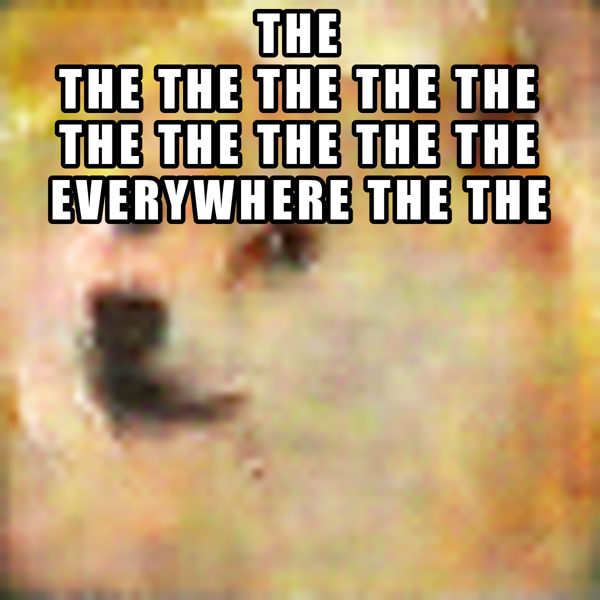

In [32]:
meme = Meme(caption, img)
meme.draw()

# All-in-one

In [33]:
from inference import generate_meme

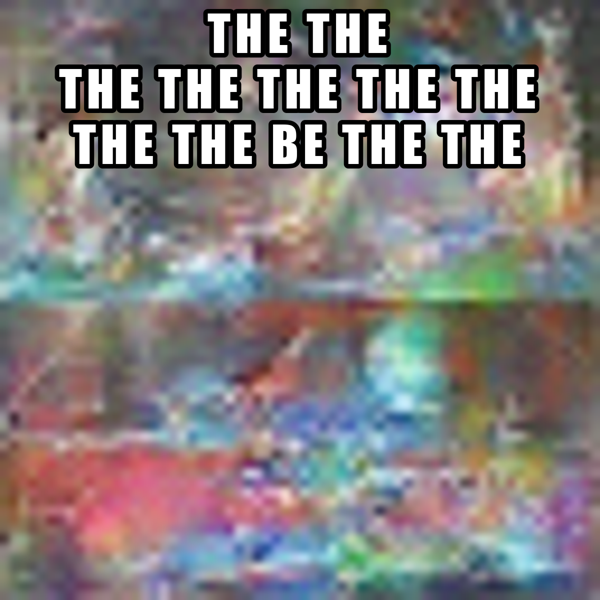

In [34]:
generate_meme(generator, encoder, decoder, data_loader, device, dataset)